In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold, PredefinedSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, make_scorer
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_path = "/content/gdrive/MyDrive/Colab Notebooks/hydrogenase/"
else:
    file_path = "./"

data = pd.read_csv(file_path+'Df-H2ase-CO.csv')
data.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(825, 808)

In [ ]:
# Split the data into features (X) and target variable (y)
X = data.drop(["Trajectory", "Frame", "Pathway-new","Binary"], axis=1)  # Features
y = data['Binary']  # Target variable
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=1)

# Split the validation & test subset into validation and test sets equally
# exclude the test set from consideration
X_val, _, y_val, _ = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1)

# oversample the training set
oversampler = RandomOverSampler(random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Combine training and validation sets for GridSearchCV
X_combined = np.concatenate((X_train_resampled, X_val), axis=0)
y_combined = np.concatenate((y_train_resampled, y_val), axis=0)

# Create test_fold array for PredefinedSplit
# -1 for training data, 0 for validation data
test_fold = np.zeros(X_combined.shape[0], dtype=int)
test_fold[:len(X_train_resampled)] = -1  # Training data
test_fold[len(X_train_resampled):] = 0   # Validation data

ps = PredefinedSplit(test_fold=test_fold)

In [ ]:
# standardize the feature set for algorithms that requires normalization
scaler = StandardScaler().fit(np.array(X_train_resampled)) # fit the scaler with the training set
# transform the combined training & validation subset
X1_combined = scaler.transform(X_combined)

In [ ]:
# scoring metrics
scoring = {
    'BA': make_scorer(balanced_accuracy_score),
    'MCC': make_scorer(matthews_corrcoef)}

In [ ]:
# Define the SVM model
svm_classifier = SVC(random_state=1)

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Grid search
grid_search_svm = GridSearchCV(estimator=svm_classifier, param_grid=param_grid_svm,
                               cv=ps, scoring=scoring, refit=False, n_jobs=-1)
grid_search_svm.fit(X1_combined, y_combined) # standardized features

# Get the best parameters without refitting
best_params = grid_search_svm.cv_results_['params'][np.argmin(grid_search_svm.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [ ]:
log_reg_classifier = LogisticRegression(max_iter=5000, random_state=1)

param_grid_log_reg = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# Grid search
grid_search_log_reg = GridSearchCV(estimator=log_reg_classifier, param_grid=param_grid_log_reg,
                                   cv=ps, n_jobs=-1, scoring=scoring, refit=False)
grid_search_log_reg.fit(X1_combined, y_combined) # standardized features

# Get the best parameters without refitting
best_params = grid_search_log_reg.cv_results_['params'][np.argmin(grid_search_log_reg.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'C': 1, 'l1_ratio': 0, 'solver': 'sag'}


In [ ]:
# Define the KNN model
knn_classifier = KNeighborsClassifier()

# Set up the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Grid search
grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn,
                               cv=ps, scoring=scoring, refit=False, n_jobs=-1)
grid_search_knn.fit(X_combined, y_combined) # unstandardized features

# Get the best parameters without refitting
best_params = grid_search_knn.cv_results_['params'][np.argmin(grid_search_knn.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.73065476 0.73065476 0.7016369  0.7016369  0.72172619 0.72172619
 0.70386905 0.70907738        nan 0.6875            nan 0.70535714
        nan 0.71279762        nan 0.74627976 0.73065476 0.73065476
 0.7016369  0.7016369  0.72172619 0.72172619 0.70386905 0.70907738]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.4454354  0.4454354  0.35841294 0.35841294 0.3838269  0.3838269
 0.35454888 0.36540993        nan 0.38516444        nan 0.41608944
        nan 0.41551513        nan 0.49255952 0.4454354  0.4454354
 0.35841294 0.35841294 0.3838269  0.3838269  0.35454888 0.36540993]
  warnings.warn(


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)

param_grid_rf = {
    'max_depth': [10, 12, 15, 20, None],
    'ccp_alpha': [0, 0.0004, 0.0005, 0.0007, 0.001],
    'max_samples': [0.7, 0.8, 0.9, 0.95]
}

# Perform GridSearchCV with the predefined split and scoring
grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    cv=ps,  # Using predefined split for cross-validation
    scoring=scoring,  # Use custom scoring metric(s)
    refit=False,  # Do not refit on the entire training data
    n_jobs=-1
)

# Fit the GridSearchCV model on the combined training set
grid_search_rf.fit(X_combined, y_combined)  # Using unstandardized features

# Get the best parameters without refitting
best_params = grid_search_rf.cv_results_['params'][np.argmin(grid_search_rf.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.9}


In [ ]:
# Define the Gradient Boosting model
gb_classifier = GradientBoostingClassifier(n_estimators=500, tol=0.0005, random_state=1)

# Set up the parameter grid for Gradient Boosting
param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9]
}

# Grid search
grid_search_gb = GridSearchCV(estimator=gb_classifier, param_grid=param_grid_gb,
                              cv=ps, scoring=scoring, refit=False, n_jobs=-1)
grid_search_gb.fit(X_combined, y_combined) # unstandardized features

# Get the best parameters without refitting
best_params = grid_search_gb.cv_results_['params'][np.argmin(grid_search_gb.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'subsample': 0.7}


In [ ]:
# Define the AdaBoost model
ada_classifier = AdaBoostClassifier(random_state=1)

# Set up the parameter grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.1, 0.5, 1.0, 1.2]
}

# Grid search
grid_search_ada = GridSearchCV(estimator=ada_classifier, param_grid=param_grid_ada,
                               cv=ps, scoring=scoring, refit=False, n_jobs=-1)
grid_search_ada.fit(X_combined, y_combined) # unstandardized features

# Get the best parameters without refitting
best_params = grid_search_ada.cv_results_['params'][np.argmin(grid_search_ada.cv_results_['rank_test_BA'])]

# Output the best parameters
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}


In [ ]:
algorithms = ['SVM', 'Logistic Regression', 'kNN', 'Random Forest', 'Gradient Boost', 'AdaBoost']
gs_all = [grid_search_svm, grid_search_log_reg, grid_search_knn, grid_search_rf, grid_search_gb, grid_search_ada]

# Use 'np.argmin' to find the index of the best score for each GridSearchCV object
ba_all = [gs.cv_results_['mean_test_BA'][np.argmin(gs.cv_results_['rank_test_BA'])] for gs in gs_all]
mcc_all = [gs.cv_results_['mean_test_MCC'][np.argmin(gs.cv_results_['rank_test_BA'])] for gs in gs_all]

results = pd.DataFrame.from_dict({
    'algorithm': algorithms,
    'BA validation set': [f'{ba:.2f}' for ba in ba_all],
    'MCC validation set': [f'{mcc:.2f}' for mcc in mcc_all],
}, orient='columns')

display(results)

,algorithm,BA test set,MCC test set
0,SVM,0.86,0.68
1,Logistic Regression,0.84,0.68
2,kNN,0.75,0.49
3,Random Forest,0.91,0.82
4,Gradient Boost,0.87,0.76
5,AdaBoost,0.88,0.77


In [ ]:
# save/load the search results
import pickle

option = 'read'

if option == 'write':
    pickle_file = open(file_path+"algorithm_test_gsall.pkl", "wb")
    pickle.dump(gs_all, pickle_file)
else:
    pickle_file = open(file_path+"algorithm_test_gsall.pkl", "rb")
    [grid_search_svm, grid_search_log_reg, grid_search_knn, grid_search_rf, grid_search_gb, grid_search_ada] = pickle.load(pickle_file)
pickle_file.close()

In [ ]:
# check the details of selected search
search_results = grid_search_rf
check_metric = "BA" # "BA" or "MCC"

# retrieve the information
ba_scores = search_results.cv_results_[f'mean_test_{check_metric}']
hyperparam_combi = search_results.cv_results_['params']
# print results for each model in the search
for combi, ba in zip(hyperparam_combi, ba_scores):
    print(f"{str(combi):<65}         {ba:.3f}")

{'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.7}                     0.944
{'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.8}                     0.945
{'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.9}                     0.946
{'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.95}                    0.949
{'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.7}                     0.949
{'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.8}                     0.954
{'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.9}                     0.953
{'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.95}                    0.956
{'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.7}                     0.961
{'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.8}                     0.959
{'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.9}                     0.962
{'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.95}                    0.964
{'ccp_alpha': 0, 'max_depth': 20, 'max_s

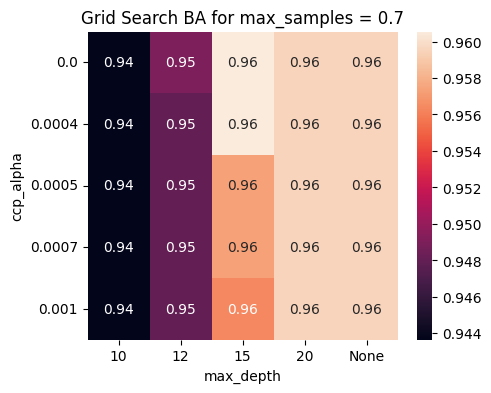

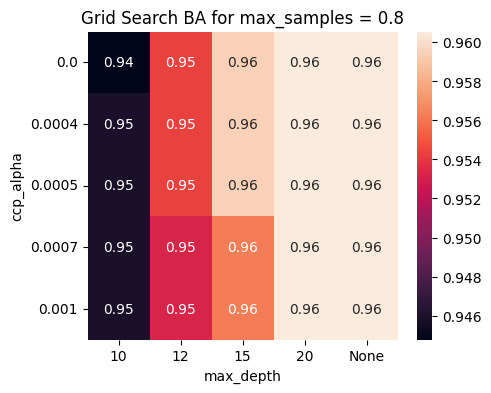

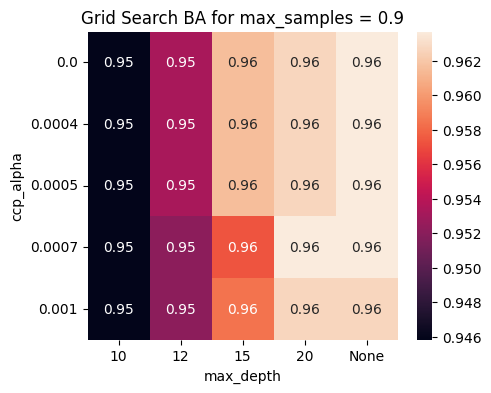

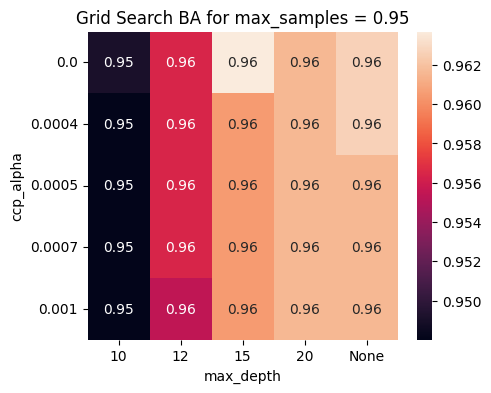

In [ ]:
param_grid = param_grid_rf
hyperparam_ax = 'max_samples'
hyperparam_x = 'max_depth'
hyperparam_y = 'ccp_alpha'

cv_scores_mat = ba_scores.reshape(len(param_grid[hyperparam_y]),
                                 len(param_grid[hyperparam_x]),
                                 len(param_grid[hyperparam_ax]))

for i in range(cv_scores_mat.shape[2]):
    cv_scores_df = pd.DataFrame(cv_scores_mat[:,:,i],
                                columns=[x if x else 'None' for x in param_grid[hyperparam_x]],
                                index=param_grid[hyperparam_y])
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    sns.heatmap(cv_scores_df, annot=True, ax=ax)
    plt.title(f'Grid Search {check_metric} for max_samples = {param_grid[hyperparam_ax][i]}')
    plt.xlabel(hyperparam_x)
    plt.ylabel(hyperparam_y)
    ax.tick_params(axis='y', rotation=0)
    plt.show()